In [20]:
import numpy as np
import pandas as pd
import time
import random
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report
from tqdm import tqdm
import torch
from torch import nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchmetrics
import tenseal as ts

In [6]:
# Importing, balancing, scaling and splitting the dataset into train and test set
df = pd.read_csv(r"C:\Users\invite1\Downloads\Manigandan Ramadasan\Code\top_feature_df_rfr40.csv")

grouped = df.groupby('Label')
df = grouped.apply(lambda x: x.sample(grouped.size().min(), random_state=73).reset_index(drop=True))

x = df.drop(["Label"], axis = 1)
y = df["Label"]
# scaler = preprocessing.MinMaxScaler()
scaler = preprocessing.StandardScaler()
x = scaler.fit_transform(x)

x_train, x_test_20, y_train, y_test_20 = train_test_split(x, y, test_size=0.2, random_state=42)
x_train=torch.from_numpy(x_train).float().unsqueeze(dim=1)
x_test_20=torch.from_numpy(x_test_20).float().unsqueeze(dim=1)
y_train=torch.from_numpy(np.array(y_train)).float().unsqueeze(dim=1)
y_test_20=torch.from_numpy(np.array(y_test_20)).float().unsqueeze(dim=1)
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test_20.shape}")
print(f"y_test shape: {y_test_20.shape}")

x_train shape: torch.Size([681185, 1, 40])
y_train shape: torch.Size([681185, 1])
x_test shape: torch.Size([170297, 1, 40])
y_test shape: torch.Size([170297, 1])


In [12]:
train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

In [16]:
class ONEDCNN(torch.nn.Module):
    def __init__(self):
        super(ONEDCNN, self).__init__()
        self.conv_layer = torch.nn.Conv1d(in_channels=1, out_channels=1, kernel_size=5, stride=1)
        self.dense_layer_1 = torch.nn.Linear(in_features=36, out_features=8)
        self.dense_layer_2 = torch.nn.Linear(in_features=8, out_features=1)
        
    def forward(self, x):
        x = self.conv_layer(x)
        x = x * x
        x = x.view(x.size(0), -1)
        x = self.dense_layer_1(x)
        x = x * x
        x = self.dense_layer_2(x)
        return x

In [9]:
# Function to calculate accuracy, recall, precision and f1 - score
def metrics_fn(y_true, y_pred, others=False):
    for i in range(len(y_pred)):
        if y_pred[i]<0.5:
            y_pred[i] = 0
        else:
            y_pred[i] = 1
            
    accuracy = torchmetrics.Accuracy(task="binary", num_classes=2)
    acc = accuracy(y_pred, y_true)
    
    if others==True:
        rec = torchmetrics.Recall(task="binary", num_classes=2)
        prec = torchmetrics.Precision(task="binary", num_classes=2)
        recall = rec(y_pred, y_true)
        precision = prec(y_pred, y_true)
        f1_score = 2*((precision*recall)/(precision+recall))
        del accuracy, rec, prec
        return acc, recall, precision, f1_score
    
    return acc

In [10]:
# function to train the model
def train(model, train_loader, criterion, optimizer, n_epochs=10):
    loss_dict = {}
    acc_dict = {}
    model.train()
    for epoch in range(1, n_epochs+1):
        train_loss = 0.0
        train_acc = 0.0
        for data, target in train_loader:
            output = model(data)
            loss = criterion(output, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
#             scheduler.step(loss)
            train_loss += loss.item()
            train_acc += metrics_fn(target, torch.sigmoid(output))
        train_loss = train_loss / len(train_loader)
        train_acc = train_acc / len(train_loader)
        loss_dict[epoch] = train_loss
        acc_dict[epoch] = train_acc
        if epoch%3 == 0:
            print(f"Epoch: {epoch} Training Loss: {train_loss} || Training Accuracy: {train_acc} || Learning Rate: {optimizer.param_groups[0]['lr']}")
    model.eval()
    return model, loss_dict, acc_dict

Epoch: 3 Training Loss: 0.25568160380921734 || Training Accuracy: 0.9299313426017761 || Learning Rate: 0.001
Epoch: 6 Training Loss: 1.0098868526524645 || Training Accuracy: 0.9394791126251221 || Learning Rate: 0.001
Epoch: 9 Training Loss: 0.2031410688029344 || Training Accuracy: 0.9412404894828796 || Learning Rate: 0.001
Epoch: 12 Training Loss: 0.15399140844363768 || Training Accuracy: 0.944232165813446 || Learning Rate: 0.001
Epoch: 15 Training Loss: 0.24378420834628006 || Training Accuracy: 0.9443013668060303 || Learning Rate: 0.001
Epoch: 18 Training Loss: 0.3077340699784452 || Training Accuracy: 0.9426236748695374 || Learning Rate: 0.001
Epoch: 21 Training Loss: 0.22069169434500743 || Training Accuracy: 0.9447371363639832 || Learning Rate: 0.001
Epoch: 24 Training Loss: 0.19944471782857356 || Training Accuracy: 0.945510745048523 || Learning Rate: 0.001


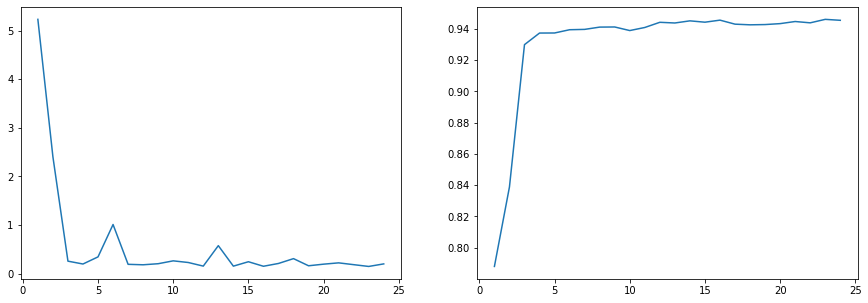

In [22]:
torch.manual_seed(42)
model = ONEDCNN()

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model, loss_dict, acc_dict = train(model, train_loader, criterion, optimizer, 24)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5)) 
x_coord, y_coord = zip(*(loss_dict.items()))
ax1.plot(x_coord, y_coord)
x_coord, y_coord = zip(*(acc_dict.items()))
ax2.plot(x_coord, y_coord)

In [23]:
model.conv_layer.weight

Parameter containing:
tensor([[[ 0.0728,  0.0464, -0.1043,  0.1461, -0.0627]]], requires_grad=True)